In [75]:
import numpy as np #矩阵运算库
import pandas as pd #加载数据库
import matplotlib.pyplot as plt #绘图库

In [76]:
from sklearn.preprocessing import StandardScaler, LabelEncoder #数据标准化+标签值
from sklearn.model_selection import train_test_split #数据分割
from sklearn.metrics import classification_report, accuracy_score #分类结果评价标准

In [78]:
class BPNN:

    def __init__(self, hidden_layer=None, alpha=1e-2, precision=None, gradient_method="SGD",
                 optimizer_method=None, activity_fun="sigmoid", epochs=1000):

        self.hidden_layer = hidden_layer  # 隐藏层结构
        self.alpha = alpha  # 学习率步长
        self.precision = precision #提前终止循环的精确率
        self.gradient_method = gradient_method #使用的下降算法 SGD BGM....
        self.optimizer_method = optimizer_method #使用的优化方法
        self.layers = []  # 神经网络层次及各层神经元数列表

        self.activity_fun = af.activity_functions(activity_fun) #使用的激活函数 relu、sigmoid...
        self.out_activity = af.activity_functions("softmax")  # 输出层的激活函数 将最大值index返回
        self.epochs = epochs #迭代的次数
        self.weights = None  # 神经网络的权重
        self.bias = None  # 神经网络的偏置量
        self.loss_values = []  # 训练的损失误差 绘图使用

        # 关于优化方法的参数设置
        self.mmt, self.bias_mmt = None, None
        self.beta = 0.9  # 动量法的超参数

        # 关于adagrad、rmsprop优化方法的参数
        self.h, self.bias_h = None, None
        self.epsilon = 1e-8
        self.rou = 0.9

        # 关于adam优化方法的参数
        self.m, self.v = None, None
        self.bias_m, self.bias_v = None, None
        self.beta1, self.beta2 = 0.9, 0.999
        self.eta = 1e-2  # adam的学习率
        self.t = 0  # 迭代次数

        # 多分类相关变量值
        self.y_one_hot = None  # 目标值的编码
        self.accuracy_list_validate = []  # 存储每次训练后的测试精度
        self.accuracy_list_train = []  # 存储每次训练后的训练精度

    def initialize_network(self, n_features, n_class):
        
        """
        n_features: 输入结点数，即样本特征数
        n_class: 输出层神经元数，即类别数
        
        """        
        self.layers.append(n_features)  # 输入层结点数
        
        if self.hidden_layer:
            self.layers.extend(list(self.hidden_layer.values()))  # 各个隐层的结点数
        self.layers.append(n_class)  # 输出层结点数

        self.bias = [np.random.randn(b) for b in self.layers[1:]]
        
        # 便于数值运算，每层权重维度为（输出节点数，输入结点数）
        self.weights = [np.random.randn(out_h, in_h)
                        for in_h, out_h in zip(self.layers[:-1], self.layers[1:])]

        if self.optimizer_method == "mmt":  # 动量法
            self.mmt = [np.zeros((out_h, in_h))
                        for in_h, out_h in zip(self.layers[:-1], self.layers[1:])]
            self.bias_mmt = [np.zeros(b) for b in self.layers[1:]]
        elif self.optimizer_method in ["adagrad", "rmsprop"]:
            self.h = [np.zeros((out_h, in_h))
                      for in_h, out_h in zip(self.layers[:-1], self.layers[1:])]
            self.bias_h = [np.zeros(b) for b in self.layers[1:]]
        elif self.optimizer_method == "adam":
            self.m = [np.zeros((out_h, in_h))
                      for in_h, out_h in zip(self.layers[:-1], self.layers[1:])]
            self.v = [np.zeros((out_h, in_h))
                      for in_h, out_h in zip(self.layers[:-1], self.layers[1:])]
            self.bias_m = [np.zeros(b) for b in self.layers[1:]]
            self.bias_v = [np.zeros(b) for b in self.layers[1:]]
        # else:
        #     raise AttributeError("优化方法选择有误：mmt / adagrad / rmsprop / adam")

    def one_hot(self, y_train):
        """
        对目标值进行one-hot编码
        :param y_train: 目标值
        :return:
        """
        # 手写数字10分类， [0 0 0 0 0 0 1 0 0 0]
        self.y_one_hot = np.zeros((y_train.shape[0], len(set(y_train))))
        for i in range(y_train.shape[0]):
            self.y_one_hot[i, y_train[i]] = 1

    def forward_pass(self, x, ratio):
        """
        正向传播
        :param x: 样本
        :param ratio: 丢弃结点比例1 - ratio
        :return:
        """
        y_out = [x]  # 存储每层输出结点值，并经过激活函数
        for r, b, w in zip(ratio, self.bias[:-1], self.weights[:-1]):
            # 计算公式：np.dot(权重，输入) + 偏置
            z = np.dot(w, y_out[-1]) + b
            z = self.dropout(z, r)
            out_val = self.activity_fun[0](z)  # 计算激活函数输出值
            # 存储每层（包括输入层）激活函数输出值，便于反向传播计算
            y_out.append(out_val)
        # 对输出层单独处理，使用softmax激活函数
        out_val = np.dot(self.weights[-1], y_out[-1]) + self.bias[-1]
        out_val = self.out_activity(out_val)  # softmax激活
        y_out.append(out_val)
        return y_out

    def backward_pass(self, y_true, y_out):
        """
        反向传播：每次训练，更新权重和偏置，该方法实现了一次训练
        :param y_true: 真值
        :param y_out: 模型各层的输出值
        :return:
        """
        # 1、从输出层倒序开始，计算各层增量规则
        error = y_true - y_out[-1]  # 计算输出层误差
        # 各层增量的数量与各层神经元数相等
        deltas = [error]  # 输出层增量规则，交叉熵代价函数
        # 循环计算隐藏层的增量规则，从倒数第2层开始
        for i in range(len(self.layers) - 2, 0, -1):  # 步长为-1
            deltas.append(self.activity_fun[1](y_out[i]) *
                          np.dot(deltas[-1], self.weights[i]))
        # 2、从输入层开始，依次计算各层权重和偏置更新
        deltas.reverse()  # 反转，从输入层开始更新权重和偏置
        for j in range(len(self.layers) - 1):
            layer_out = np.array(y_out[j])  # 当前层的激活输出
            # np.atleast_2d转化为至少二维
            d_weight = np.atleast_2d(deltas[j]).T.dot(np.atleast_2d(layer_out))
            if self.optimizer_method == "mmt":
                # 使用动量项推动权重在一定程度上向某个特定方向调整，而不是产生立即性改变。
                self.mmt[j] = d_weight + self.beta * self.mmt[j]  # 动量思想
                self.bias_mmt[j] = deltas[j] + self.beta * self.bias_mmt[j]  # 偏置
                self.weights[j] += self.alpha * self.mmt[j]  # 更新权重
                self.bias[j] += self.alpha * self.bias_mmt[j]  # 更新偏置
            elif self.optimizer_method == "adagrad":
                # 随着学习的推进，学习率也会逐渐减少
                self.h[j] += d_weight ** 2
                self.bias_h[j] += deltas[j] ** 2
                self.weights[j] += self.alpha * 1 / np.sqrt(self.h[j] + self.epsilon) * d_weight
                self.bias[j] += self.alpha * 1 / np.sqrt(self.bias_h[j] + self.epsilon) * deltas[j]
            elif self.optimizer_method == "rmsprop":
                # 克服了AdaGrad算法中由于更新量变小而导致的学习进度停滞不前的问题
                self.h[j] = self.rou * self.h[j] + (1 - self.rou) * d_weight ** 2
                self.bias_h[j] = self.rou * self.bias_h[j] + (1 - self.rou) * deltas[j] ** 2
                self.weights[j] += self.alpha * 1 / np.sqrt(self.h[j] + self.epsilon) * d_weight
                self.bias[j] += self.alpha * 1 / np.sqrt(self.bias_h[j] + self.epsilon) * deltas[j]
            elif self.optimizer_method == "adam":
                # 对其各种各样的算法的优点实现了兼收并蓄，因此屡屡表现出比其他最优化算法更为突出的性能
                self.t += 1
                # 一阶矩、二阶矩
                self.m[j] = self.beta1 * self.m[j] + (1 - self.beta1) * d_weight
                self.v[j] = self.beta2 * self.v[j] + (1 - self.beta2) * d_weight ** 2
                self.bias_m[j] = self.beta1 * self.bias_m[j] + (1 - self.beta1) * deltas[j]
                self.bias_v[j] = self.beta2 * self.bias_v[j] + (1 - self.beta2) * deltas[j] ** 2
                # 修正
                m_hat = self.m[j] / (1 - self.beta1 ** self.t)
                v_hat = self.v[j] / (1 - self.beta2 ** self.t)
                bias_m_hat = self.bias_m[j] / (1 - self.beta1 ** self.t)
                bias_v_hat = self.bias_v[j] / (1 - self.beta2 ** self.t)
                # 更新权重和偏置
                self.weights[j] += self.eta * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.bias[j] += self.eta * bias_m_hat / (np.sqrt(bias_v_hat) + self.epsilon)
            else:
                # 普通的单层梯度下降算法
                self.weights[j] += self.alpha * d_weight  # 更新权重
                # 偏置增加量，计算公式：学习率 * 增量
                d_bias = self.alpha * deltas[j]
                self.bias[j] += d_bias  # 更新偏置

    def fit_net(self, X_train, y_train, X_validate, y_validate):
        """
        BP神经网络训练算法，分为正向传播和反向传播
        :param X_train: 训练集
        :param y_train: 训练集对应的目标值
        :return:
        """
        n_samples, n_features = X_train.shape
        n_class = len(set(y_train))  # 类别数
        # 1、神经网络初始化
        self.initialize_network(n_features, n_class)
        # 2、对目标值进行one-hot编码
        self.one_hot(y_train)

        # 随机丢弃结点
        ratio = [0.8 * 0.95 ** i for i in range(len(self.bias))]  # 丢弃比例列表
        # 越接近于输入层，丢弃的比例相对低
        ratio.reverse()

        # 3、BP神经网络训练过程
        for epoch in range(self.epochs):
            if self.gradient_method == "SGD":
                # 随机梯度下降算法
                x_y = np.c_[X_train, self.y_one_hot]  # 合并样本
                np.random.shuffle(x_y)  # 随机化
                y_predict = np.zeros((X_train.shape[0], n_class))
                for i in range(n_samples):
                    x, y_true = x_y[i, :n_features], x_y[i, n_features:]
                    # 正向传播
                    y_out = self.forward_pass(x, ratio)
                    y_predict[i, :] = y_out[-1]  # 存储训练过程中每个样本的激活输出
                    # 反向传播
                    self.backward_pass(y_true, y_out)
                loss_mean = np.mean((y_predict - x_y[:, n_features:]) ** 2)
                self.loss_values.append(loss_mean)

                # 每一次训练的精度
                y_test_hat = self.predict(X_validate)
                y_train_hat = self.predict(X_train)
                acc_train = accuracy_score(y_train, y_train_hat)
                acc_validate = accuracy_score(y_validate, y_test_hat)
                print("epoch = %d, acc_train = %.5f, acc_validate = %.5f"
                      % (epoch + 1, acc_train, acc_validate))
                self.accuracy_list_validate.append(acc_validate)
                self.accuracy_list_train.append(acc_train)

            elif self.gradient_method == "BGD":
                pass
            elif self.gradient_method == "MBGD":
                pass
            else:
                raise AttributeError("梯度下降算法选择有误。。。")

            # 停机规则：两次训练误差损失差小于给定的精度，即停止训练
            if self.precision and len(self.loss_values) > 2 and \
                    np.abs(self.loss_values[-1] - self.loss_values[-2]) < self.precision:
                break

    @staticmethod
    def dropout(y_out, ratio):
        """
        随机丢弃百分比1 - ratio的神经元结点
        :param y_out: 某一层的神经元数
        :param ratio: 选择更新结点的比例
        :return:
        """
        if y_out.ndim == 1:
            m, n = y_out.shape[0], 1
        else:
            m, n = y_out.shape
        # 通过伯努利分布，选取百分比ratio的神经元结点，即丢弃1 - ratio
        num = bernoulli.rvs(size=m * n, p=ratio).reshape(y_out.shape)
        # 对没有被dropout的神经元做一个rescale，弥补因为随即删除节点而
        # 造成的输出减少的副作用，保持期望输出大小不变
        y_out = y_out * num * 1 / (1 - ratio)
        return y_out


    def plt_loss_curve(self, legend=None):
        """
        绘制神经网络训练过程的损失下降曲线
        :param legend: 是否添加图例
        :return:
        """
        plt.plot(self.loss_values, lw=1.5, label=legend)
        plt.xlabel("Epochs", fontdict={"fontsize": 12})
        plt.ylabel("Loss", fontdict={"fontsize": 12})
        plt.title("MultiLayer Neural Network Optimizer of Error Loss Curve", fontdict={"fontsize": 14})
        if legend:
            plt.legend()
        plt.grid(ls=":")

    def predict_prob(self, X_test):
        """
        预测样本属于某个类别的概率
        :param X_test: 测试样本
        :return:
        """
        y_hat_prob = []
        for i in range(X_test.shape[0]):
            x = X_test[i]  # 取单个测试样本
            for b, w in zip(self.bias[:-1], self.weights[:-1]):
                z = np.dot(w, x) + b
                x = self.activity_fun[0](z)
            x = np.dot(self.weights[-1], x) + self.bias[-1]
            x = self.out_activity(x)
            y_hat_prob.append(x)
        return np.array(y_hat_prob)

    def predict(self, X_test):
        """
        预测测试样本所属的类别
        :param X_test: 测试样本
        :return:
        """
        y_hat_prob = self.predict_prob(X_test)
        return np.argmax(y_hat_prob, axis=1)

epoch = 1, acc_train = 0.89045, acc_validate = 0.87548
epoch = 2, acc_train = 0.88545, acc_validate = 0.87000
epoch = 3, acc_train = 0.89783, acc_validate = 0.88095
epoch = 4, acc_train = 0.93208, acc_validate = 0.91464
epoch = 5, acc_train = 0.93268, acc_validate = 0.91500
epoch = 6, acc_train = 0.93589, acc_validate = 0.91631
epoch = 7, acc_train = 0.93574, acc_validate = 0.91286
epoch = 8, acc_train = 0.92479, acc_validate = 0.91083
epoch = 9, acc_train = 0.92759, acc_validate = 0.90714
epoch = 10, acc_train = 0.93682, acc_validate = 0.91298
epoch = 11, acc_train = 0.96039, acc_validate = 0.94131
epoch = 12, acc_train = 0.95119, acc_validate = 0.92524
epoch = 13, acc_train = 0.95122, acc_validate = 0.92845
epoch = 14, acc_train = 0.95354, acc_validate = 0.92929
epoch = 15, acc_train = 0.96640, acc_validate = 0.94333
epoch = 16, acc_train = 0.94080, acc_validate = 0.91488
epoch = 17, acc_train = 0.96348, acc_validate = 0.94262
epoch = 18, acc_train = 0.96542, acc_validate = 0.93798
e

<IPython.core.display.Javascript object>


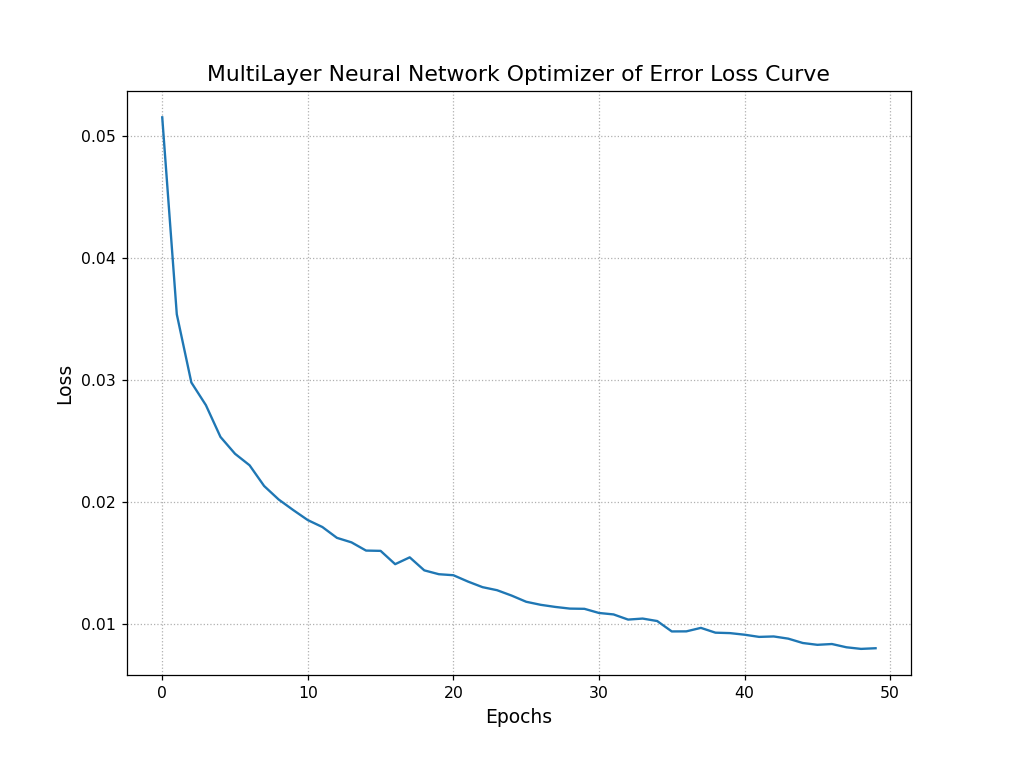

<IPython.core.display.Javascript object>


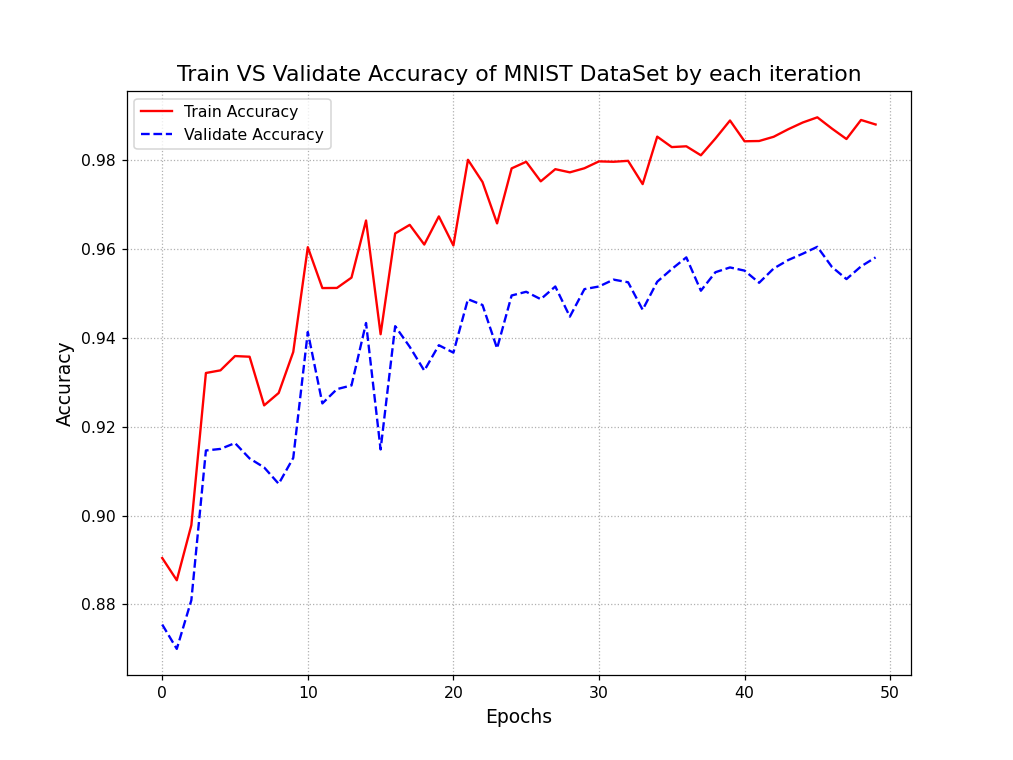

In [96]:
    mnist = pd.read_csv(r"/home/rain/data/zhc/dataset/Mnist/train.csv").values
    X, y = mnist[:, 1:], mnist[:, 0]
    pca_ = PCA(0.95).fit(X)  # 保留95%的贡献率，返回训练后的主成分分析对象
    X = pca_.transform(X)  # 转换降维之后的数据
    X = StandardScaler().fit_transform(X)
    y = LabelEncoder().fit_transform(y)
    X_train, X_validate, y_train, y_validate = \
        train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    ambp = BPNN(hidden_layer={"1": 512,"2":256,"3":124},
                                        epochs=50, precision=1e-8,
                                        optimizer_method="adam",
                                        activity_fun="leakyrelu")
    setattr(ambp, "eta", 0.005)  # adam参数学习率设置为0.005
    ambp.fit_net(X_train, y_train, X_validate, y_validate)
    plt.figure(figsize=(8, 6))
    ambp.plt_loss_curve()  # 误差损失曲线
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(ambp.accuracy_list_train, "r-", label="Train Accuracy")
    plt.plot(ambp.accuracy_list_validate, "b--", label="Validate Accuracy")
    plt.legend()
    plt.xlabel("Epochs", fontdict={"fontsize": 12})
    plt.ylabel("Accuracy", fontdict={"fontsize": 12})
    plt.title("Train VS Validate Accuracy of MNIST DataSet by each iteration", fontdict={"fontsize": 14})
    plt.grid(ls=":")
    plt.show()

In [97]:
minst_test = pd.read_csv(r"/home/rain/data/zhc/dataset/Mnist/test.csv").values
X_test = pca_.transform(minst_test)
y_pred = ambp.predict(X_test)
print("BP神经网络优化方法adam，测试样本分类报告如下：")

BP神经网络优化方法adam，测试样本分类报告如下：


In [98]:
pd.DataFrame(y_pred).to_csv("./Answer_3.csv")